# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [25]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [26]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [27]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [28]:
#your turn

#1) Merging offers and transaction dataframes
df = pd.merge(df_offers, df_transactions, on='offer_id')
# print(df.head())

#2) Making pivot table 
matrix = df.pivot_table(index='customer_name', columns='offer_id', values='n')
# print(matrix.head())

#3) Filling NaNs in matrix with zeros to indicate that the customer didnt respond

matrix = matrix.fillna(0)
print(matrix)


offer_id        1    2    3    4    5    6    7    8    9    10 ...    23  \
customer_name                                                   ...         
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0 ...   0.0   
Barnes         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
Bell           0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bennett        0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
Brooks         0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
Brown          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   
Butler         1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

This is a matrix representing all feature values:

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.]


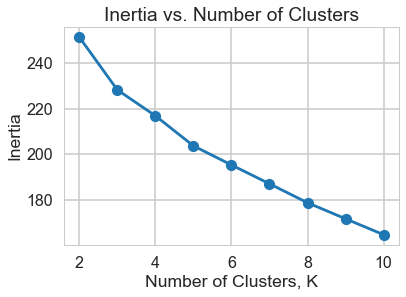

This is an array of all cluster labels:

[4 1 2 4 1 1 2 4 1 4 0 2 4 0 1 2 1 2 4 1 4 1 1 0 2 5 5 1 1 2 1 1 1 3 1 4 1
 4 0 4 2 2 1 1 4 3 4 1 1 0 1 5 1 2 3 4 2 1 4 1 1 1 0 4 4 2 2 1 0 1 5 1 3 4
 1 4 2 3 1 2 5 0 5 2 4 4 4 5 1 1 3 4 1 4 5 1 4 5 3 1]

This a count of the number of datapoints in each cluster using k=6:

0     8
1    36
2    16
3     7
4    24
5     9
dtype: int64


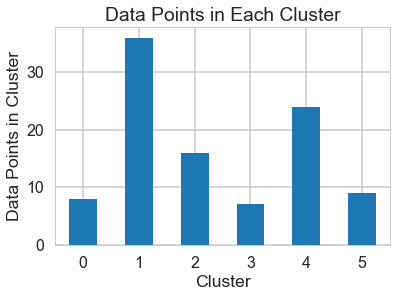

In [29]:
# your turn
#1) I believe that lower SS values will represent better clusterings since data points will be closer to centroid of cluster.

#2) Creating numpy matrix with only columns representing the offers (i.e., all our features)
matrix_val = matrix.values
print("This is a matrix representing all feature values:\n")
print(matrix_val[0])


#3) Importing K-means clustering from SKlearn and matplotlib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#a) using for loop to vary the number of clusters and compute the SS or Inertia

ks = range(2,11) #setting range of clusters to vary over
inertias =[] #initializing empty list to store inertias calulcated for each model


for k in ks:
    #Creating model with k clusters
    model = KMeans(n_clusters=k, random_state=42)
    
    #Training model with data
    model.fit(matrix_val)
    
    #Appending inertia to inertias list
    inertias.append(model.inertia_)

#b) Making plot of inertias and number of clusters to make 'elbow' graph
plt.plot(ks, inertias, '-o')
plt.xlabel("Number of Clusters, K")
plt.ylabel("Inertia")
plt.title("Inertia vs. Number of Clusters")
plt.show()

## From looking at the graph, selecting K=6

#4) Making a bar chart showing number of points in each cluster

#a) Developing model with n_clusters = 6, selected from the 'elbow' graph

model_elbow = KMeans(n_clusters=6, random_state=42)
model_elbow.fit(matrix_val)


#b) Printing out points in each cluster
clus_labs = model_elbow.labels_ 
print("This is an array of all cluster labels:\n")
print(clus_labs)

#c) Performing value count on cluster labels to determine number of data points in each cluster

clus_labs_counts = pd.value_counts(clus_labs).sort_index() # to use pandas value counts we must convert array to pandas series
print("\nThis a count of the number of datapoints in each cluster using k=6:\n")
print(clus_labs_counts) # this gives us a pandas series

#d) Making a bar chart of number of datapoints in each cluster
clus_labs_counts.plot(kind='bar', rot=0)
plt.xlabel("Cluster")
plt.ylabel("Data Points in Cluster")
plt.title("Data Points in Each Cluster")
plt.show()


#5) Its difficult to clearly determine the visual 'elbow'. Looking at the Inertia vs. Number of Clusters graph, the optimal number of cluster can be 5 or 6.




### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

This is a list to Silhouette scores calculated with clusters ranging from 2-10:

 [0.091748715087503513, 0.11542407037894219, 0.096702583606931222, 0.14531568820332333, 0.13313126627114877, 0.13073950771832585, 0.12397572901124844, 0.1202465110942483, 0.12695143123424532]


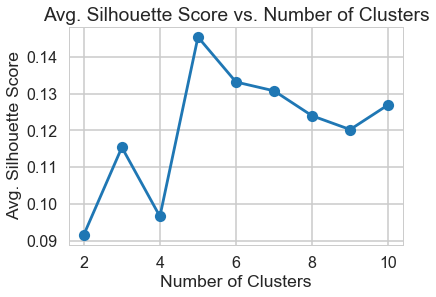

[0 1 2 3 4]
100


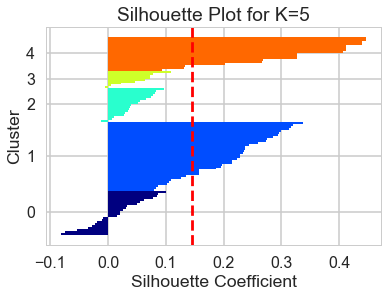

In [43]:
# Your turn.
#1) Importing Silhouette scoring and sample functions from sklearn
from sklearn.metrics import silhouette_samples, silhouette_score


#2)Looping to calculate the silhouette scores for kmeans with clusters ranging from 2 to 10
sil_avg_scores = [] # list to hold average silhouette scores

cluster_range = range(2,11)
for k in cluster_range:
    
    #Creating model
    model_sil= KMeans(n_clusters = k, random_state = 42)
    
    #Training model and making predictions
    cluster_pred = model_sil.fit_predict(matrix_val)
    
    #Calculating silhouette score
    sil_avg_score = silhouette_score(matrix_val, cluster_pred)
    
    #Appending scores to 'sil_avg_scores' list
    sil_avg_scores.append(sil_avg_score)

print("This is a list to Silhouette scores calculated with clusters ranging from 2-10:\n\n", sil_avg_scores)


#3) Plotting avg silhouette scores for each cluster
plt.plot(cluster_range, sil_avg_scores, '-o')
plt.xlabel("Number of Clusters")
plt.ylabel("Avg. Silhouette Score")
plt.title("Avg. Silhouette Score vs. Number of Clusters")
plt.show()

## Using the silhouette score function it is much clearer that the optimal number of clusters is 5. 
## Before using the elbow plot is was difficult to tell if optimal number was 5 or 6. From the elbow plot I choose 6 clusters.

#1) Making a silhouette plot for optimal silhouette score

#a) Creating model object
model_opt_sa = KMeans(n_clusters = 5, random_state=42)
#b) Fitting model
model_opt_sa.fit(matrix_val)

#c) Importing color mapping from matplotlib and numpy
from matplotlib import cm
import numpy as np

#d)Extracting customer labels from model
opt_sa_labels = model_opt_sa.labels_

#e) Determing unique cluster labels
cluster_labels_sa = np.unique(opt_sa_labels)
print(cluster_labels_sa)

#f) Fining total number of cluster samples
n_clusters_sa = opt_sa_labels.shape[0]
print(n_clusters_sa) #There are 100 samples or rows of clusters

#g) Using sklearn to find Silhouette values for each sample
silhouette_val_sa = silhouette_samples(matrix_val, opt_sa_labels)

#h) Developing for loop to produce horizontal bar graphs for each cluster

y_lower, y_upper = 0,0 #initializing lower and upper limits for y axis

yticks = [] #empty list to hold yticks 

for i, c in enumerate(cluster_labels_sa): #iterating over list of unique cluster labels
    
    # Finding all silhouette values associated with each unique cluster label
    c_silhouette_vals = silhouette_val_sa[opt_sa_labels == c]
    
    #Sorting values in ascending order
    c_silhouette_vals.sort()
    
    #Determining y upper limit based on length of silhouettes for each cluster
    y_upper = y_upper + len(c_silhouette_vals)
    
    #Using 'jet' color map
    color = cm.jet(float(i)/5)
    
    #Making horizontal bar plot
    plt.barh(range(y_lower, y_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    
    #Finding midpoint of y-axis to later use to center y-ticks
    yticks.append((y_lower + y_upper)/2)
    
    #Determining y lower limit (so we can stack graphs one on top of another)
    y_lower = y_lower +len(c_silhouette_vals)
    
#i) Plotting vertical line to show average silhouette score for KMeans model with 5 clusters

#silhouette avg score for n_clusters = 5
silhouette_avg =  np.mean(silhouette_val_sa) 

#plotting vertical line
plt.axvline(silhouette_avg, color ='red', linestyle='--')

#j) Adding axis labels and adjusting yticks for super-imposed plot
plt.yticks(yticks, cluster_labels_sa)#adjusting yticks to show actual cluter labelslike 0,1,...
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.title('Silhouette Plot for K=5')
plt.show()

## From looking at the silhouette plot it evident that, even though this model is optimal, the low silhouette scores
## for clusters 0,2,3 is an indicator that this is a sub-optimal model. 



### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

[1 0 4 1 0 2 4 1 2 1 2 4 1 0 1 4 0 4 1 2 1 1 2 2 4 3 3 0 0 4 1 1 2 2 1 1 2
 1 2 1 4 4 1 0 1 2 1 1 0 0 0 3 4 4 2 1 4 1 1 0 0 1 0 1 1 4 4 0 2 0 3 0 2 1
 0 1 4 2 1 4 3 0 3 4 1 1 1 3 0 1 0 1 0 1 3 2 1 3 0 2]


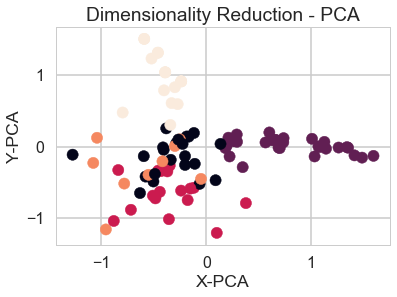

In [31]:
#your turn

#1) Using KMeans and optimal number of clusters (n_clusters=5) to group data into cluster labels
#a) Setting up KMeans model with 5 clusters & training
model_opt = KMeans(n_clusters=5, random_state=42)
model_opt.fit(matrix_val)

#b) Extracting cluster labels
cluster_label_opt = model_opt.labels_
print(cluster_label_opt)


#2) Using PCA to reduce dimensionality of 32 features int 2-dimensions
from sklearn.decomposition import PCA

#a) creating model
model=PCA(n_components=2)

#b) training and transforming model
pca_features = model.fit_transform(matrix_val)
# print(pca_features)

#c) Extracting PCA features to plot into 'x' and 'y'
x_pca = pca_features[:, 0]
y_pca = pca_features[:, 1]

#3) Making dataframe of 'customer_name', corresponding 'cluster label' from model, and PCA features 'x' and 'y'

df_opt_pca = pd.DataFrame({'customer_name': matrix.index.values, 'cluster_label':cluster_label_opt, 'x_pca': x_pca, 'y_pca': y_pca})


#d) Making scatter plot

plt.scatter(df_opt_pca['x_pca'], df_opt_pca['y_pca'],c=df_opt_pca['cluster_label'] )
plt.xlabel('X-PCA')
plt.ylabel('Y-PCA')
plt.title('Dimensionality Reduction - PCA')
plt.show()



What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

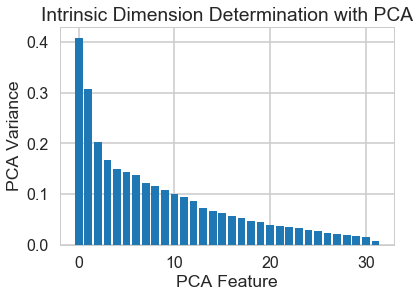

In [32]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(matrix_val)

# Do the rest on your own :)
#1) Finding the number of features in our model
features = range(pca.n_components_)#n_components_ returns single number. Range allows us to make x axis labels

#2) Finding corresponding PCA variance for each feature determined by model
feature_var = pca.explained_variance_

#3) Making a bar plot to see which features are contributing to model the most. High variance columns contribute the most
plt.bar(features, feature_var)
plt.xlabel("PCA Feature")
plt.ylabel("PCA Variance")
plt.title("Intrinsic Dimension Determination with PCA")
plt.show()

## Looking at the graph, a possible value for the optimal number of dimensions could be 5. 
## The variance after the 5th dimension begins to slowly drop and not make major contributions to the model. 


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [33]:
# Your turn

In [60]:
#I) Affinity Propagation_
#1) Importing affinity propgation from sklearn
from sklearn.cluster import AffinityPropagation
#2) Instantiating & fitting the model
af = AffinityPropagation().fit(matrix_val)

#3) Detrmining number of clusters
n_clusters = len(af.cluster_centers_indices_)
print("AFINITY PROPOGATION:\n")
print("The number of clusters generated by the Affinity Propagation model is:", n_clusters)

#4) Calculating the silhouette score
#a) Determining labels generated by model
labels = af.labels_
#b) Calculating the silhouette score
sil_score_AP = silhouette_score(matrix_val, labels)
print( "The average silhouette score is for Affinity Propagation is:", sil_score_AP)


#II) Spectral Clustering
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters =8, random_state=42).fit(matrix_val)

labels_SC = sc.labels_ #printing labels
sil_score_SC = silhouette_score(matrix_val, labels_SC)
print("\nSPECTRAL CLUSTERING:\n\n")
print("The number of clusters generated by the Spectral Clustering model is the default:", 8)
print( "The average silhouette score is for Spectral Clustering is:", sil_score_SC)

#III) Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=5).fit(matrix_val)

labels_AC = ac.labels_
sil_score_AC = silhouette_score(matrix_val, labels_AC)

labels_AC_unique= np.unique(labels_AC)

print("\nAGGLOMERATIVE CLUSTERING:\n\n")
print( "The average silhouette score is for Agglomerative Clustering is:", sil_score_AC)
print("Agglomerative clustering uses {} labels".format(labels_AC_unique))
#IV) DBSCAN 
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1).fit(matrix_val)

labels_DB = db.labels_
# print(labels_DB)

#finding unique number of labels
labels_DB_unique = np.unique(labels_DB)


sil_score_DB = silhouette_score(matrix_val, labels_DB)
print("\nDBSCAN:\n\n")
print( "The average silhouette score is for DBSCAN is:" ,sil_score_DB )
print("DBSCAN uses {} labels".format(labels_DB_unique))


##Agglomerative clustering looks to give the best results as it yields a silhouette score of .14 using 5 clusters.

AFINITY PROPOGATION:

The number of clusters generated by the Affinity Propagation model is: 14
The average silhouette score is for Affinity Propagation is: 0.123465236045

SPECTRAL CLUSTERING:


The number of clusters generated by the Spectral Clustering model is the default: 8
The average silhouette score is for Spectral Clustering is: 0.0526822430984

AGGLOMERATIVE CLUSTERING:


The average silhouette score is for Agglomerative Clustering is: 0.140897399708
Agglomerative clustering uses [0 1 2 3 4] labels

DBSCAN:


The average silhouette score is for DBSCAN is: 0.0127152032749
DBSCAN uses [-1  0  1  2  3] labels
